In [1]:
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
 
################################################################################
#############  Functions for data loading #####################################
################################################################################

## comb data 
def open_ErYb_data(data_path, header=2):
    # keys to read out as string
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Al_ErYb", "fb_Yb_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    # # Read the CSV file
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    # Convert the strings to Decimal for the given keys
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    # reindex data
    data.index = range(len(data))
 
    return data[list(types.keys())]

 
 ## Yb shift data
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
################################################################################
#############  Functions to find optical frequencies with comb equation ########
################################################################################
 
# frequency calculations for Yb clock
def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"]
 
 
################################################################################
#############################  Load data #######################################
################################################################################
 
path = "/Users/smt3/Documents/GitHub/atomic-clock/st-interp/three_clocks/"

# load comb data
data_ErYb = open_ErYb_data(path + "20240813_Deglitched_ErYb_only1.dat")
 
# load Yb shift data
shift_data_Yb = open_shiftfile_Yb(path + "20240813_Yb_Freq_Shifts.txt")
 
 
################################################################################
###############  get Yb optical frequencies #############################
################################################################################
 
compute_nuYb_ErYb(data_ErYb)

##notes on data collection 
## Nick, Tara - comb 
## Dave H - Al clock 
## Andrew L - Yb clock  (island filter)
## Jun Yi - Sr clock 
## time division - Cesium, microwave clocks, mazers, ethers, always running (Jeff) 
## frequency division - clocks run occasionally (Dave, Andrew, combs)

In [2]:
 
################################################################################
#########################  Data Processing #####################################
################################################################################

## Change comb mjd type to float  
common_mjd = data_ErYb["MJD"].astype(float)
nuYb = data_ErYb["nuYb"].astype(float)

## Extract only "IS_GOOD" data for analysis 
good_condition_yb = shift_data_Yb["IS_GOOD"] == 1
shift_data_Yb_good = shift_data_Yb[good_condition_yb].reset_index(drop=True)
print(shift_data_Yb_good.head(10))

            MJD         shift  IS_GOOD
0  60535.689228  6.300000e+07     True
1  60535.689239  6.300000e+07     True
2  60535.689249  6.300000e+07     True
3  60535.689259  6.300000e+07     True
4  60535.689270  6.300000e+07     True
5  60535.689280  6.300000e+07     True
6  60535.689291  6.300000e+07     True
7  60535.689301  6.300000e+07     True
8  60535.689312  6.300000e+07     True
9  60535.689322  6.300000e+07     True


In [3]:

## Find common MJD values 
# Length of the 'MJD' column
len_comb = len(common_mjd)                 
len_Yb = len(shift_data_Yb_good['MJD'])

## Find intersecting indices and adjust data accordingly 
#function to extract element as close to target as possible w/out going over
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data[inx] <= target:
            inx += 1
        else:
            return inx  

#function to extract element as close to target as possible w/out going under 
def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data[len(data)-inx] >= target:
            inx += 1
        else:
            return len(data)-inx  


print("first comb time point: ", common_mjd[0])
print("first good Yb time point: ", shift_data_Yb_good["MJD"][0])
print("since Yb starts later, start comb observations at index:", lb_extract(target = shift_data_Yb_good["MJD"][0], data = common_mjd))

print("last comb time point: ", common_mjd[len(common_mjd)-1])
print("last good Yb time point: ", shift_data_Yb_good["MJD"][len(shift_data_Yb_good["MJD"])-1])
print("Since Yb ends earlier, end comb observations at index: ", ub_extract(target = shift_data_Yb_good["MJD"][len(shift_data_Yb_good["MJD"])-1], data = common_mjd))

#common comb MJD index w/ Yb 
comb = pd.DataFrame()
comb["MJD"] = common_mjd[564:17255] 
comb["nuYb"] = nuYb[564:17255]


first comb time point:  60535.682346
first good Yb time point:  60535.68922818
since Yb starts later, start comb observations at index: 564
last comb time point:  60535.911951
last good Yb time point:  60535.89320398
Since Yb ends earlier, end comb observations at index:  17255


In [4]:
## View attributes of the complete data set
print(comb.columns)
print(shift_data_Yb_good.columns)

## Change comb values to high precision decimal (for zip compatability later)
comb["nuYb"] = [Decimal(i) for i in comb["nuYb"]]

Index(['MJD', 'nuYb'], dtype='object')
Index(['MJD', 'shift', 'IS_GOOD'], dtype='object')


0


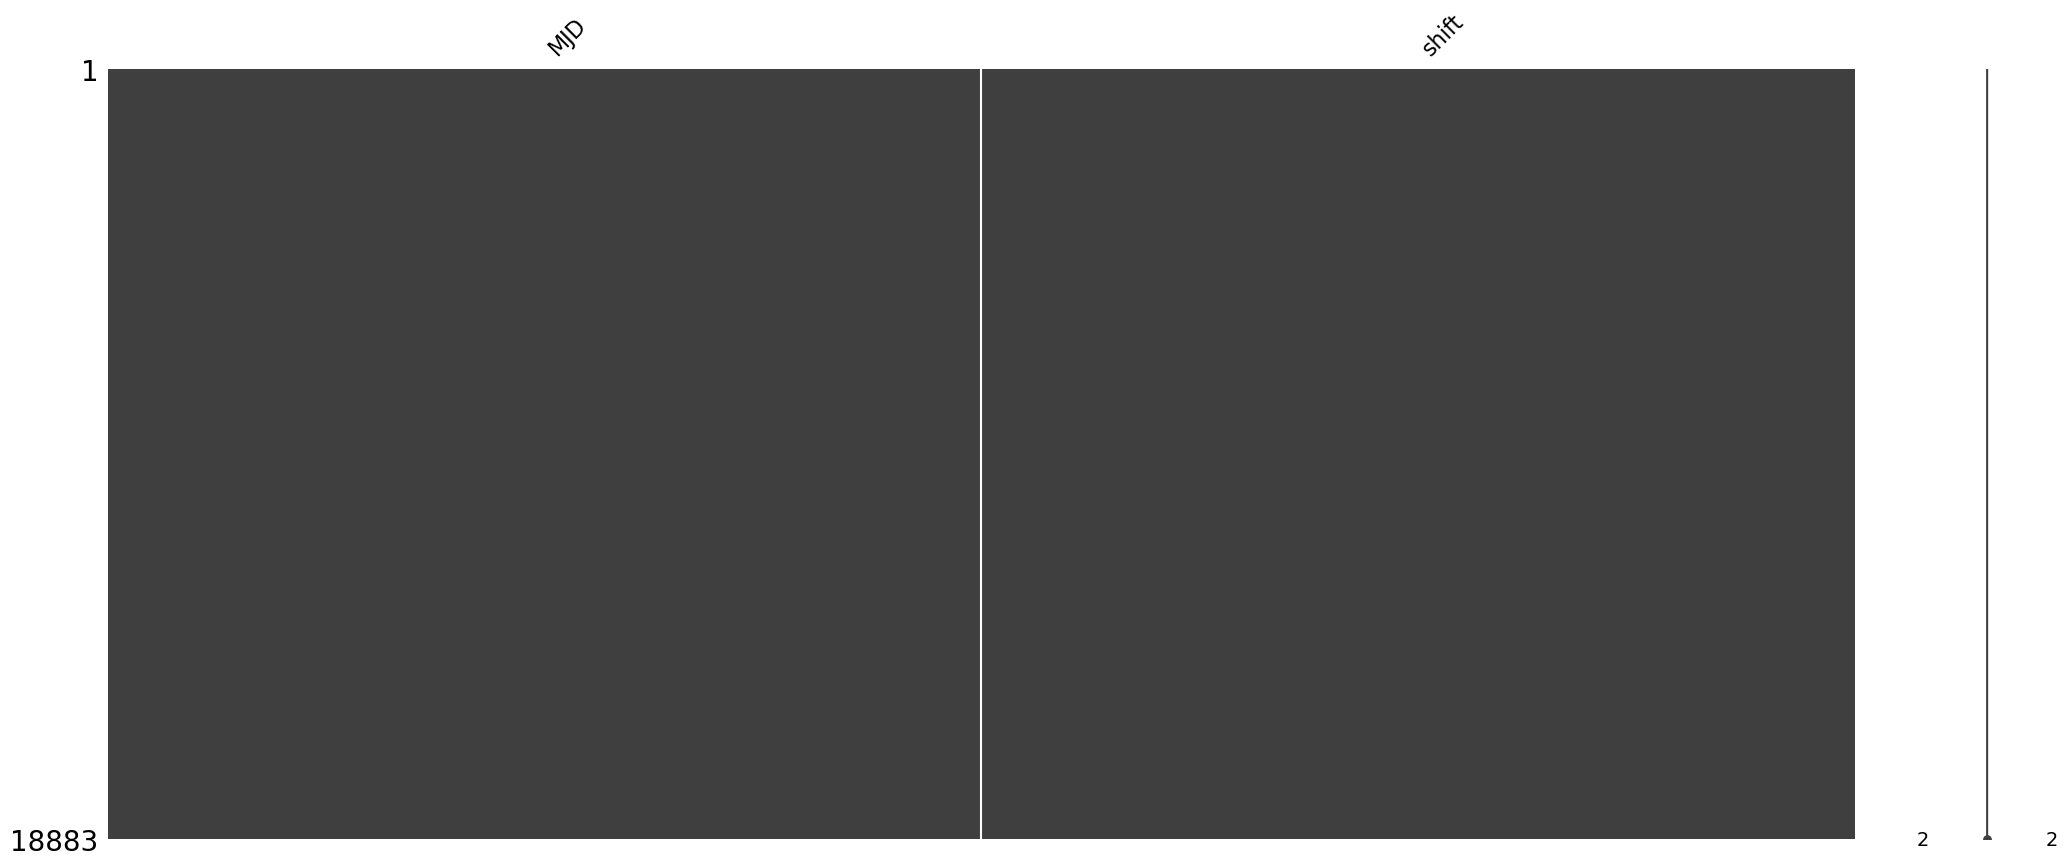

count    1.888300e+04
mean     6.300000e+07
std      5.260140e-01
min      6.300000e+07
25%      6.300000e+07
50%      6.300000e+07
75%      6.300000e+07
max      6.300000e+07
Name: shift, dtype: float64

In [6]:
## Visualize gaps in data before imputing 
import missingno as msno
atts = ["MJD", "shift"]
miss_inx_Yb = pd.isnull(shift_data_Yb_good["shift"])
print(miss_inx_Yb.sum())
msno.matrix(shift_data_Yb_good[atts])
plt.show()

shift_data_Yb_good["shift"].describe() 